# 0 Setup

## 0.1 Installing & importing required Python libraries

In [63]:
%pip install pandas
%pip install pyflightdata
%pip install matplotlib
%pip install tqdm
%pip install seaborn
%pip install logging
%pip install cartopy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for logging: filename=logging-0.4.9.6-py3-none-any.whl size=29515 sha256=fa17298c6aa4859111c76e01132bfa18849f6e93795927b23a208315db850294
  Stored in directory: /Users/thealteredmg/Library/Caches/pip/wheels/30/80/e6/0a01576c333eb17cb6f3ad46889726bbb140ff661beae5ad2a
Successfully built logging
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 6.8 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 9.1 MB/s eta 0:00:

In [136]:
import pandas as pd
from tqdm import tqdm
from pyflightdata import FlightData
import matplotlib.pyplot as plt
import numpy as np


## 0.2 Loading & inspecting data

In [65]:

# Load the data
file_path = 'data/IVDA_A3_2024_Company_FlightData.csv'  # Replace with your actual file path
data = pd.read_csv(file_path, sep=';')

# Investigating data structure & understand volume
display(data.head())
print(f'Size of data: {len(data)} rows')


,Flight number,Aircraft type,Departure,Destination,Segments,Service class,Total Distance [km],CO2 RFI 2 + emissions jet fuel production 15.2% [t],Department
0,"6,00E+32",NaN,NaN,NaN,1.0,Y,913.0,0.1045576,HR
1,"6,00E+32",NaN,NaN,NaN,1.0,B,913.0,0.150562944,Marketing
2,2I3116,NaN,IQT,TPP,1.0,Y,504.0,0.0916184,Operations
3,2I3116,NaN,IQT,TPP,1.0,Y,504.0,0.0916184,IT
4,2I3134,NaN,PCL,LIM,2.0,Y,1082.0,0.1715776,Finance


Size of data: 7464 rows


In [68]:
# Understand how many NaN-values we are facing in "Departure" & "Destination"
print(data[['Departure', 'Destination']].isna().sum())

Departure      3204
Destination    3204
dtype: int64


In [66]:
print(f"{len(data['Flight number'].unique())} unique flight numbers in dataset.")

2299 unique flight numbers in dataset.


## 0.3 Split data into 2 datasets ("data_trips" & "data_flights")

In [70]:
# Setup of a "data_trips" Dataframe, containing all individual trips
data_trips = data[["Flight number", "Aircraft type", "Segments", "Service class", "Department"]]

# Setup of a "data_flights" Dataframe, containing all flights
data_flights_temp = data[["Flight number", "Departure", "Destination", "Total Distance [km]", "CO2 RFI 2 + emissions jet fuel production 15.2% [t]"]]
data_flights = data_flights_temp.drop_duplicates(subset='Flight number', keep='last') # As the whole dataset only has about 2k unique flight numbers, the rest can be dropped.


# 1 Reduction of missing data of departure and destination - 4 points

## 1.1 Understand volume of NaN-values and how to find the most recent flight information

In [72]:
# Check for NaN-values in "Destination" and "Departure" for unique flight-numbers
missing_values = data_flights[['Departure', 'Destination']].isna().sum()
print(missing_values)


Departure      1029
Destination    1029
dtype: int64


In [2]:
# Setup of pyflightdata API
fd = FlightData()

# Check layout of API-response (example)
flight = fd.get_history_by_flight_number('LX1266')

print(flight)
print(flight[0])

print(flight[0]["airport"]["origin"]["code"]["iata"])
print(flight[0]["airport"]["destination"]["code"]["iata"])

[{'identification': {'number': {'default': 'LX1266', 'alternative': '2L1266'}, 'callsign': 'None', 'codeshare': 'None'}, 'status': {'live': False, 'text': 'Scheduled', 'estimated': 'None', 'ambiguous': False, 'generic': {'status': {'text': 'scheduled', 'type': 'departure', 'color': 'gray', 'diverted': 'None'}, 'eventTime': {'utc': 'None', 'local': 'None'}}}, 'aircraft': {'model': {'code': '290', 'text': 'None'}, 'registration': 'None', 'serialNo': 'None', 'age': 'None', 'restricted': 'None', 'availability': {'serialNo': 'None', 'age': 'None'}}, 'owner': 'None', 'airline': {'name': 'Swiss', 'code': {'iata': 'LX', 'icao': 'SWR'}}, 'airport': {'origin': {'name': 'Zurich Airport', 'code': {'iata': 'ZRH', 'icao': 'LSZH'}, 'position': {'latitude': 47.464722, 'longitude': 8.549167, 'country': {'name': 'Switzerland', 'code': 'CH'}, 'region': {'city': 'Zurich'}}, 'timezone': {'name': 'Europe/Zurich', 'offset': 3600, 'abbr': 'CET', 'abbrName': 'Central European Time', 'isDst': False}, 'visible':

In [79]:
most_recent_departure = None
most_recent_index = -1

# Iterate over the API response to find the flight with the most recent departure time
for index, flight in enumerate(flight):
    # Get the departure time in milliseconds
    departure_time_millis = flight['time']['scheduled']['departure_millis']
    
    # Check if this is the most recent departure
    if most_recent_departure is None or departure_time_millis > most_recent_departure:
        most_recent_departure = departure_time_millis
        most_recent_index = index

# Output the index and departure time of the most recent flight
print(f"Most recent departure is at index: {most_recent_index}, Departure time (milliseconds): {most_recent_departure}")


Most recent departure is at index: 0, Departure time (milliseconds): 1730268300000


## 1.2 Retrieve missing "Departure" and "Destination" values

In [83]:

def retrieve_missing_info(row):
    if (pd.isnull(row['Departure']) or pd.isnull(row['Destination'])):
        try:
            if len(fd.get_flights(row['Flight number'])) > 0:
                flight_info = fd.get_history_by_flight_number(row['Flight number'])  # Retrieve flight information based on past flights.
                if len(flight_info) > 0:
                    row['Departure'] = flight_info[0]["airport"]["origin"]["code"]["iata"] # Get most recent departure IATA-code
                    row['Destination'] = flight_info[0]["airport"]["destination"]["code"]["iata"] # Get most recent destination IATA-code
                    print(f"{row.name}/{len(data)}")
        except Exception as e:
            print(f"Error retrieving departure for flight {row['Flight number']}: {e}")
    return row

In [84]:
t1_data_flights = data_flights.apply(retrieve_missing_info, axis=1)

48/7464
54/7464
60/7464
61/7464
63/7464
65/7464
69/7464
HTML code 402 - Retry in 10 seconds...
72/7464
78/7464
79/7464
88/7464
89/7464
HTML code 402 - Retry in 10 seconds...
91/7464
95/7464
98/7464
HTML code 402 - Retry in 10 seconds...
102/7464
104/7464
HTML code 402 - Retry in 10 seconds...
116/7464
120/7464
153/7464
HTML code 402 - Retry in 10 seconds...
156/7464
159/7464
160/7464
HTML code 402 - Retry in 10 seconds...
202/7464
203/7464
204/7464
HTML code 402 - Retry in 10 seconds...
231/7464
241/7464
HTML code 402 - Retry in 10 seconds...
256/7464
269/7464
HTML code 402 - Retry in 10 seconds...
292/7464
293/7464
312/7464
321/7464
HTML code 402 - Retry in 10 seconds...
324/7464
339/7464
351/7464
357/7464
360/7464
HTML code 402 - Retry in 10 seconds...
367/7464
372/7464
HTML code 402 - Retry in 10 seconds...
377/7464
387/7464
HTML code 402 - Retry in 10 seconds...
HTML code 402 - Retry in 10 seconds...
414/7464
416/7464
417/7464
HTML code 402 - Retry in 10 seconds...
423/7464
424/746

Departure      417
Destination    417
dtype: int64


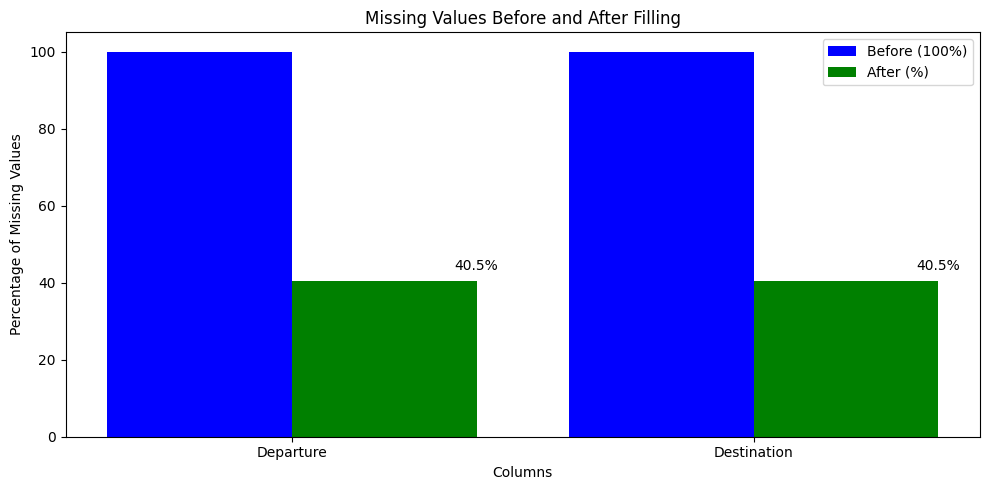

In [102]:

# Plot before filling missing values
missing_before = missing_values

# After filling missing values
missing_after = t1_data_flights[['Departure', 'Destination']].isnull().sum()

print(missing_after)

# Plotting as bar chart
labels = ['Departure', 'Destination']
before_counts = [missing_before['Departure'], missing_before['Destination']]
after_counts = [missing_after['Departure'], missing_after['Destination']]

# Calculate percentage of the After counts relative to Before counts
percentage_after = [(count / before) * 100 for count, before in zip(after_counts, before_counts)]

x = np.arange(len(labels))

# Plotting the bar chart
plt.figure(figsize=(10, 5))  # Adjusting figure size
plt.bar(x, [100] * len(before_counts), width=0.4, label='Before (100%)', color='blue', align='center')  # 100% for Before
plt.bar(x + 0.4, percentage_after, width=0.4, label='After (%)', color='green', align='center')

plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values Before and After Filling')
plt.xticks(x + 0.2, labels)
plt.legend()

# Adding value annotations on the "After" bars
for i in range(len(percentage_after)):
    plt.text(i + 0.6, percentage_after[i] + 2, f'{percentage_after[i]:.1f}%', 
             ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()  # Adjust layout to make it look better
plt.show()




Before: 1029
After: 417

## 1.3 Clean up after data retrieval

In [103]:
# Drop rows containing "NaN" in data_flights Dataframe
columns_to_check = ['Departure', 'Destination']
t1_data_flights_cleaned = data_flights.dropna(subset=columns_to_check)

print(f"{len(t1_data_flights_cleaned)} unqiue flights remain after cleanup.")

# Save progress to file
t1_data_flights_cleaned.to_csv('data/t1_FlightData.csv', index=False, sep=';')
data_trips.to_csv('data/t1_TripData.csv', index=False, sep=';')

1882 unqiue flights remain after cleanup.


## 1.4 Reasoning

Initially it was observed through ```print(len(data['Flight number'].unique()))``` that there are indeed only 2299 unique flight numbers in this dataset. As the flight number acts as the unique identifier for a flight, the dataset could be split into two, a trips dataset ```data_trips``` and a flights dataset ```data_flights```. From the latter, all duplicates could be dropped, which significantly reduced the effort required to find the missing departure and destination information (shown as "NaN" in pandas).

The Python library ```pyflightdata```, more specifically, its function ```get_history_by_flight_number(flight_number)``` was used to fetch the missing departure and destination data. ```get_history_by_flight_number(flight_number)``` takes a flight number and returns a list of occurrences of this flight, including IATA-codes.

>The function ```get_history_by_flight_number(flight_number)``` returns numerous entries for the same flight ID's with sometimes different destination/departure codes, the first entry to the list was deemed appropriate as the most accurate representation of correct data as it is the most recent (see ch. 1.1 for proof).

As can be seen in the above bar-chart, the developed function ```retrieve_missing_info()``` was used to iterate over the whole dataset and fill the missing values. The missing data could be significantly reduced from 1029 flights with NaN-values to 417 (for both departure and destination).

For some flights, the ``pyflightapi`` returns a HTTP-402 error indicating that a paid account is required to fetch requested information. To further reduce the amount of flights with NaN-values, such an account would be required. This measure was not taken for this task, and therefore some unique flight-numbers with NaN-values remain. These rows were dropped (see ch. 1.3) to not further interfere with upcoming tasks.

# 2 Airport code errors - 1 point

In [104]:
# Load airport data
data_airports = pd.read_csv('data/iata-icao.csv')

# Load data_flights dataset as pandas df
data_flights = pd.read_csv('data/t1_FlightData.csv', sep=';')

## 2.1 Find airport code errors

In [105]:
# Convert the valid IATA codes to a set for quick lookup
valid_iata_set = set(data_airports['iata'].str.upper())  # Convert to uppercase for consistency

# Add "IATA-Error" column for tracking
data_flights["IATA-Error"] = 0

# Function to check and correct IATA codes
def check_airport_codes(row):
    if row['Departure'] not in valid_iata_set:
        row['Departure'] = None
        row["IATA-Error"] = 1
    if row['Destination'] not in valid_iata_set:
        row['Destination'] = None
        row["IATA-Error"] = 1
    return row

error_data_before = data_flights.apply(check_airport_codes, axis=1)


## 2.2 Resolving IATA-Errors

In [92]:
def solve_iata_error(row):
    if row['IATA-Error'] == 1:
        try:
            if len(fd.get_flights(row['Flight number'])) > 0:
                flight_info = fd.get_history_by_flight_number(row['Flight number'])  # Retrieve flight information based on past flights.
                if len(flight_info) > 0:
                    row['Departure'] = flight_info[-1]["airport"]["origin"]["code"]["iata"]  # Adjust this based on actual response structure
                    row['Destination'] = flight_info[-1]["airport"]["destination"]["code"]["iata"]  # Adjust this based on actual response structure
                    row['IATA-Error'] = 0
                    print(f"{row.name}/{len(error_data_before)}")
        except Exception as e:
            print(f"Error retrieving departure for flight {row['Flight number']}: {e}")
    return row

In [93]:
error_data_after = error_data_before.apply(solve_iata_error, axis=1)

69/1882
253/1882
447/1882
489/1882
644/1882
HTML code 402 - Retry in 10 seconds...
1056/1882
1365/1882
1366/1882
1367/1882
1372/1882
1373/1882
HTML code 402 - Retry in 10 seconds...
1427/1882
1472/1882
HTML code 402 - Retry in 10 seconds...
1540/1882
1574/1882
1575/1882
1711/1882
HTML code 402 - Retry in 10 seconds...
1872/1882
1878/1882


In [106]:
missing_before = (error_data_before['IATA-Error'] == 1).sum()

missing_after = (error_data_after['IATA-Error'] == 1).sum()

print(f"Rows with faulty IATA-codes before cleanup: {missing_before}")
print(f"Rows with faulty IATA-codes after cleanup: {missing_after}")

Rows with faulty IATA-codes before cleanup: 34
Rows with faulty IATA-codes after cleanup: 15


## 2.3 Plotting airport error development

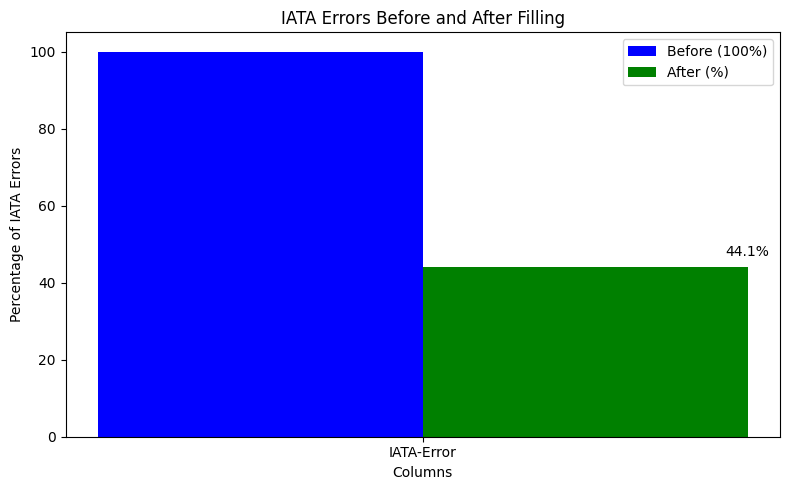

In [108]:
# Plot before filling missing values
missing_before = (error_data_before['IATA-Error'] == 1).sum()

# After filling missing values
missing_after = (error_data_after['IATA-Error'] == 1).sum()

# Plotting
labels = ['IATA-Error']
before_counts = [missing_before]
after_counts = [missing_after]

# Calculate percentage of the After count relative to Before count
percentage_after = [(count / before) * 100 for count, before in zip(after_counts, before_counts)]

x = range(len(labels))

# Plotting
plt.figure(figsize=(8, 5))  # Adjusting figure size
plt.bar(x, [100] * len(before_counts), width=0.4, label='Before (100%)', color='blue', align='center')  # Before as 100%
plt.bar([p + 0.4 for p in x], percentage_after, width=0.4, label='After (%)', color='green', align='center')

plt.xlabel('Columns')
plt.ylabel('Percentage of IATA Errors')
plt.title('IATA Errors Before and After Filling')
plt.xticks([p + 0.2 for p in x], labels)
plt.legend()

# Adding value annotations on the "After" bars
for i in range(len(percentage_after)):
    plt.text(i + 0.6, percentage_after[i] + 2, f'{percentage_after[i]:.1f}%', 
             ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()  # Adjust layout to make it look better
plt.show()

In [109]:
# Drop rows containing "NaN" in data_flights Dataframe
t2_data_flights_cleaned = error_data_after[error_data_after['IATA-Error'] != 1]
t2_data_flights_cleaned = t2_data_flights_cleaned.drop('IATA-Error', axis=1)

print(f"Reduced size from {len(error_data_after)} to {len(t2_data_flights_cleaned)}.")

Reduced size from 1882 to 1867.


In [110]:
# Save the updated DataFrame to file
t2_data_flights_cleaned.to_csv('data/t2_FlightData.csv', index=False)  # Replace with your desired output path

## 2.4 Reasoning

IATA-codes are known and publicly available information (e.g., https://github.com/ip2location/ip2location-iata-icao/blob/master/iata-icao.csv).

In order to check for errors, the approach was taken to simply compare each IATA-code of the `data_flights` Dataframe with the above-mentioned list (see function `check_airport_codes()`). Each code (no matter because of which error) that doesn't appear on this list is considered faulty and flagged with the respective column "IATA-Error".

In a second step, the function `solve_iata_error()` checks each flagged row and resolves it by fetching the correct information from the `pyflightdata` function `get_history_by_flight_number(flight_number)`, as similarly done in step 1.

Through this, a significant improvement can be seen: from 34 errors to 15.

For some flights, the ``pyflightapi`` returns a HTTP-402 error indicating that a paid account is required to fetch requested information. To further reduce the amount of flights with NaN-values, such an account would be required. This measure was not taken for this task, and therefore some unique flight-numbers with NaN-values remain. These rows were dropped (see ch. 1.3) to not further interfere with upcoming tasks.

# 3 Derive latitude and longitude- 1 point

In [116]:
# Load your data_flights dataset as DataFrame
data_flights = pd.read_csv('data/t2_FlightData.csv')

# Load airport dataset as DataFrame
airport_data = pd.read_csv('data/iata-icao.csv')

In [117]:
# Initialize new columns with None
data_flights['dep_lat'] = None
data_flights['dep_lon'] = None
data_flights['dest_lat'] = None
data_flights['dest_lon'] = None

In [118]:
def get_lat_long_by_iata(iata_code, df):
    """Retrieve latitude and longitude for a given IATA code."""
    # Filter the DataFrame for the given IATA code
    airport_info = df[df['iata'].str.upper() == iata_code.upper()]

    if not airport_info.empty:
        # Extract latitude and longitude
        latitude = airport_info['latitude'].values[0]
        longitude = airport_info['longitude'].values[0]
        return latitude, longitude
    else:
        return None, None  # Return None if IATA code is not found

In [119]:
# Iterate through the data_flights DataFrame and fill the new columns
for index, row in data_flights.iterrows():
    if pd.isna(row['Departure']) or pd.isna(row['Destination']):
        pass
    else:
        dep_iata = row['Departure']
        dest_iata = row['Destination']
        
        # Get latitude and longitude for the departure IATA code
        dep_lat, dep_long = get_lat_long_by_iata(dep_iata, airport_data)
        data_flights.at[index, 'dep_lat'] = dep_lat
        data_flights.at[index, 'dep_lon'] = dep_long
        
        # Get latitude and longitude for the destination IATA code
        dest_lat, dest_long = get_lat_long_by_iata(dest_iata, airport_data)
        data_flights.at[index, 'dest_lat'] = dest_lat
        data_flights.at[index, 'dest_lon'] = dest_long



In [125]:
# It seems, there are some departure / destination codes which don't appear in the data_airports file provided. 
missing_values = data_flights[['dep_lat', 'dep_lon', 'dest_lat', 'dest_lon']].isna().sum()
print(missing_values)

rows_with_nan = data_flights[data_flights[['dep_lat', 'dep_lon', 'dest_lat', 'dest_lon']].isnull().any(axis=1)]

print(rows_with_nan[['Flight number', 'Departure', 'Destination', 'dep_lat', 'dep_lon', 'dest_lat', 'dest_lon']])

rows_with_dme = data_airports[data_airports['iata'] == 'TFS']
print(rows_with_dme)

dep_lat     5
dep_lon     5
dest_lat    8
dest_lon    8
dtype: int64
     Flight number Departure Destination  dep_lat  dep_lon dest_lat dest_lon
445          EK129       DXB         DME  25.2528  55.3644     None     None
487          EW253       TFS         CGN     None     None  50.8659  7.14274
640         IB3946       MAD         TFN  40.4719 -3.56264     None     None
1357          NH23       HND         ITM  35.5533  139.781     None     None
1358          NH54       CTS         HND     None     None  35.5533  139.781
1359          NH55       HND         CTS  35.5533  139.781     None     None
1363         NH864       GMP         HND     None     None  35.5533  139.781
1364         NT621       SPC         TFN  28.6265 -17.7556     None     None
1418        OZ1055       HND         GMP  35.5533  139.781     None     None
1461        S72507       DME         OVB     None     None  55.0126  82.6507
1561         TC130       DAR         NPY -6.87811  39.2026     None     None
1857   

In [128]:
# Drop rows containing "NaN" in data_flights Dataframe for cols latitude & longitude
columns_to_check = ['dep_lat', 'dep_lon', 'dest_lat', 'dest_lon']
t3_data_flights_cleaned = data_flights.dropna(subset=columns_to_check)

print(f"Number of rows before cleanup: {len(data_flights)}")
print(f"Number of rows after cleanup: {len(t3_data_flights_cleaned)}")

Number of rows before cleanup: 1867
Number of rows after cleanup: 1854


In [127]:
# Save the updated DataFrame
t3_data_flights_cleaned.to_csv('data/t3_FlightData.csv', index=False) 

## 3.1 Reasoning
Four new columns in the `data_flights` Dataframe were created to facilitate the storage of latitude & longitude information for both, departure and destination.

The longitude and latitude data was fetched using the provided `iata-icao.csv` (https://github.com/ip2location/ip2location-iata-icao/blob/master/iata-icao.csv).

It seems `pyflightdata` returns some IATA-codes (5 departures and 8 destinations) which don't appear in `iata-icao.csv`. The assumption taken at this place is, that we take `iata-icao.csv` as the single source of truth, therefore all remaining rows containing NaN for latitude & longitude values (wherever they couldn't be fetched) are dropped to not further interfere with upcoming tasks. This was the case for 13 rows.

# 4 Total distance outlier detection - 3 points

In [175]:
# Setup
data_flights = pd.read_csv('data/t3_FlightData.csv')

## 4.1 Recalculate Air distance with Geopy

In [211]:
from geopy.distance import geodesic, great_circle

data_flights["Air Distance [km]"] = None      

def calc_air_dist(row):
    if pd.isna(row['dep_lat']) or pd.isna(row['dep_lon']):
        row["Air Distance [km]"] = None
    else:
        dep = (row["dep_lat"], row["dep_lon"])
        dest = (row["dest_lat"], row["dest_lon"])
        try:
            # row["Air Distance [km]"] = round(geodesic(dep, dest).km)
            row["Air Distance [km]"] = round(great_circle(dep, dest).km)
        except:
            row["Air Distance [km]"] = None
    return row


In [212]:
tmp_dist_data_before = data_flights.apply(calc_air_dist, axis=1)

In [213]:
# Check how many rows of data remain with ['Air Distance [km]'] == None
missing_before = (tmp_dist_data_before['Air Distance [km]'] == None).sum()

print(missing_before)


0


In [219]:
print(tmp_dist_data_before['Air Distance [km]'].describe())

percentiles = tmp_dist_data_before['Air Distance [km]'].quantile([0.05, 0.25, 0.5, 0.75, 0.95])
print(percentiles)

count     1854.000000
mean      2582.701187
std       2942.793443
min          0.000000
25%        603.000000
50%       1073.000000
75%       3874.000000
max      18363.000000
Name: Air Distance [km], dtype: float64
0.05     286.00
0.25     603.00
0.50    1073.00
0.75    3874.00
0.95    9094.55
Name: Air Distance [km], dtype: float64


## 4.2 Visualization of distribution

In [187]:
from geopy.distance import great_circle
#function to calculate the air distance between two points
def recalc_distance(row):
    try: 
        lat_dept = data_airports.loc[data_airports['iata'] == row['Departure'], 'latitude'].values[0]
        long_dept = data_airports.loc[data_airports['iata'] == row['Departure'], 'longitude'].values[0]
        lat_dest = data_airports.loc[data_airports['iata'] == row['Destination'], 'latitude'].values[0]
        long_dest = data_airports.loc[data_airports['iata'] == row['Destination'], 'longitude'].values[0]
        return great_circle((lat_dept, long_dept), (lat_dest, long_dest)).kilometers
    except:
        return 'toremove'

Lower bound:  -13151.5
Upper bound:  22812.5
Number of outliers: 4


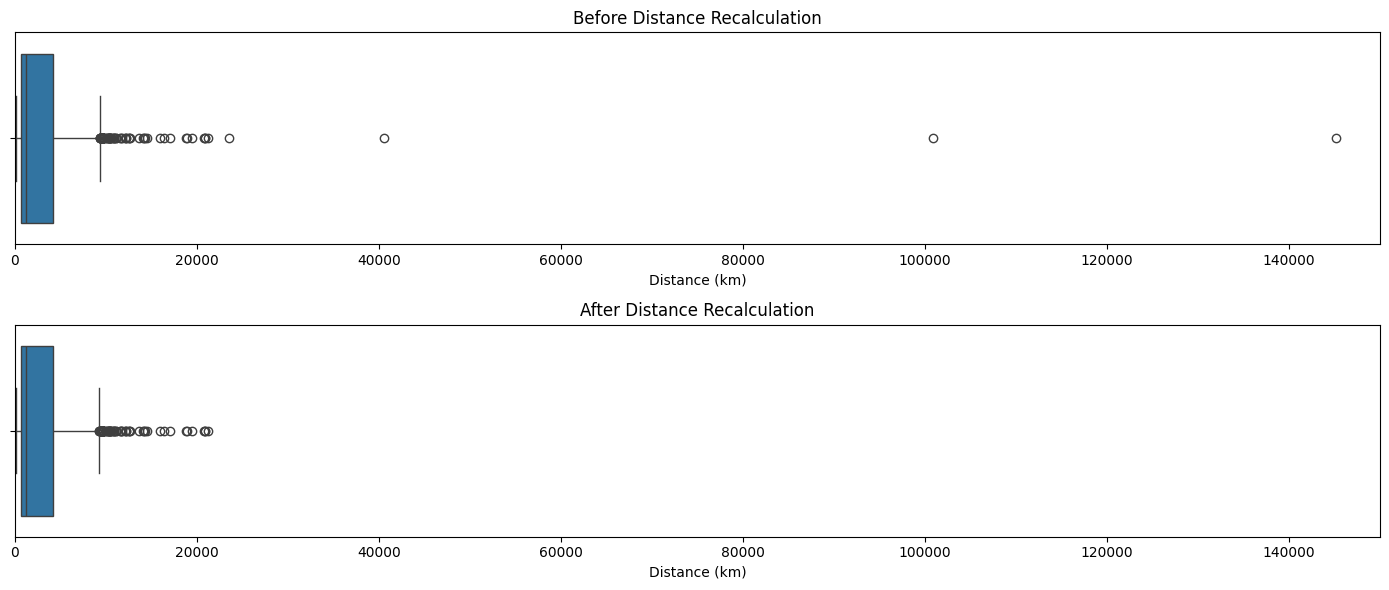


Before distance recalculation:
count      1823.000000
mean       2938.444871
std        5254.167669
min         163.000000
25%         702.000000
50%        1185.000000
75%        4164.000000
max      145129.000000
Name: Total Distance [km], dtype: float64

After distance recalculation:
count     1823.000000
mean      2781.165960
std       3205.718297
min        163.000000
25%        702.000000
50%       1183.000000
75%       4141.000000
max      21274.000000
Name: Total Distance [km], dtype: float64


In [237]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming data_after_long_lat is your DataFrame
data_after_long_lat = data_flights

# Ensure the distance column is numeric
data_after_long_lat['Total Distance [km]'] = pd.to_numeric(data_after_long_lat['Total Distance [km]'], errors='coerce')

# Identify outliers using the IQR method
q05 = data_after_long_lat['Total Distance [km]'].quantile(0.05)
q95 = data_after_long_lat['Total Distance [km]'].quantile(0.95)
IQR = q95 - q05

# Calculate lower and upper bounds for outliers
lower_bound = q05 - 1.5 * IQR
upper_bound = q95 + 1.5 * IQR

print("Lower bound: ", lower_bound)
print("Upper bound: ", upper_bound)

# Identify outliers
outliers = data_after_long_lat[(data_after_long_lat['Total Distance [km]'] < lower_bound) | 
                                (data_after_long_lat['Total Distance [km]'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")

# Recalculate distances for outliers (assumed to have recalc_distance function defined)
data_recalculated = data_after_long_lat.copy()
outlier_indices = outliers.index
data_recalculated.loc[outlier_indices, 'Total Distance [km]'] = outliers.apply(recalc_distance, axis=1)

# Visualize before and after comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))

# Boxplot before recalculation
# sns.boxplot(x=data_after_long_lat['Total Distance [km]'], ax=ax1, showfliers=True)
sns.boxplot(x='Total Distance [km]', data=data_after_long_lat, ax=ax1, showfliers=True)

ax1.set_title('Before Distance Recalculation')
ax1.set_xlabel('Distance (km)')

# Boxplot after recalculation with modified whiskers
# Calculate the actual data range excluding outliers
valid_data = data_recalculated[(data_recalculated['Total Distance [km]'] >= lower_bound) &
                                (data_recalculated['Total Distance [km]'] <= upper_bound)]

# Set the whiskers to the actual min and max of valid data
sns.boxplot(x=valid_data['Total Distance [km]'], ax=ax2, showfliers=True)
ax2.set_title('After Distance Recalculation')
ax2.set_xlabel('Distance (km)')

# Set x-axis limits
ax1.set_xlim(0, 150000)
ax2.set_xlim(0, 150000)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nBefore distance recalculation:")
print(data_after_long_lat['Total Distance [km]'].describe())

print("\nAfter distance recalculation:")
print(data_recalculated['Total Distance [km]'].describe())


In [238]:
# Save the updated DataFrame
valid_data.to_csv('data/t4_FlightData.csv', index=False) 

## 4.2 Reasoning

As mentioned in the lecture, boxplots are the main tool to visualize a distribution and its outliers. The first step is to detect outliers by chosing the intervals suitable for this task.

As shown in ch. 4.1, the distribution of flight distances are as follows:

- $0.05:     286 km$
- $0.25:     603 km$
- $0.50:    1073 km$
- $0.75:    3874 km$
- $0.95:    9094.55 km$

For this task, the assumption was taken that suitable quantiles could be Q1 with 0.05 and Q3 with 0.95.

In a next step, the IQR-method ($IQR = Q3 - Q1$) was chosen to calculate the lower ($Q1 - 1.5 * IQR$) and upper ($Q3 + 1.5 * IQR$) bounds: $-13'151.5$ (lower) & $22'812.5$ (upper).

Then, outliers were detected and saved in the variable `outliers` (4 in total) and sent to an additional step of recalculation, using the `geopy.distance.great_circle()` function, through which, the outliers indeed their distances are set to the correct value and we end up with a tidier, more truthful visualization.



# 5. Feature extraction: Identifying potential layovers - 6 points

## 5.1 Setup & Country / Continent mapping

In [242]:
!pip install countryinfo


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 602.2/602.2 kB 6.5 MB/s eta 0:00:00


In [175]:
# Setup
data_airports = pd.read_csv('data/iata-icao.csv')

In [176]:
from countryinfo import CountryInfo

data_airports['continent'] = None

def get_continent(row):
    try:
        country_code = row['country_code']
        country_info = CountryInfo(country_code)
        continent = country_info.region()  # Get continent/region
        row['continent'] = continent
        return row
    except Exception as e:
        return row  # Return None if country code is invalid or not found



In [177]:
# Apply the function to fill the new continent column with data
data_airports = data_airports.apply(get_continent, axis=1)

# Display the DataFrame
display(data_airports)

KeyboardInterrupt: 

In [317]:
# Determine if there are any airports with missing continent data
missing_continent = (data_airports['continent'] == None).sum()

print("Number of airports missing continent data: ", missing_continent)

Number of airports missing continent data:  0


In [318]:
# Save the updated DataFrame data_airports
data_airports.to_csv('data/t5_AirportData.csv', index=False) 

## 5.2 Helper Functions & Flight times

In [174]:
# Some helper functions
def convert_to_utc(timestamp):
    return pd.to_datetime(timestamp, unit='s', utc=True)

def helper_get_info(row):
    departure_iata = row['Departure']
    destination_iata = row['Destination']
        
    # Get the continent for departure and destination airports
    departure_airport = data_airports[data_airports['iata'] == departure_iata]
    destination_airport = data_airports[data_airports['iata'] == destination_iata]

    # Get continent data for departure and destination
    departure_continent = departure_airport['continent'].values[0]  # Get the first value
    destination_continent = destination_airport['continent'].values[0]  # Get the first value

    return departure_iata, destination_iata, departure_continent, destination_continent

In [4]:
# Save departure & arrival times for every flight
def flight_times(row):
    try:
        if len(fd.get_flights(row['Flight number'])) > 0:
            flight_info = fd.get_history_by_flight_number(row['Flight number'])  # Retrieve flight information based on past flights.
            if len(flight_info) > 0:
                arrival_time_secs = flight_info[0]['time']['scheduled']['arrival'] # Get most recent arrival time
                departure_time_secs = flight_info[0]['time']['scheduled']['departure'] # Get most recent departure time
                row['arrival_time_secs'] = arrival_time_secs
                row['departure_time_secs'] = departure_time_secs
                row['arrival_time_utc'] = convert_to_utc(arrival_time_secs)
                row['departure_time_utc'] = convert_to_utc(departure_time_secs)
                print(f"{row.name}/{len(data_flights)}")

                return row
    except Exception as e:
        print(f"Error retrieving departure for flight {row['Flight number']}: {e}")

In [39]:
# Setup of new dataframe for flight 
data_flights = pd.read_csv('data/t4_FlightData.csv')

data_flight_times_tmp = data_flights
data_flight_times_tmp['arrival_time_secs'] = None
data_flight_times_tmp['departure_time_secs'] = None
data_flight_times_tmp['arrival_time_utc'] = None
data_flight_times_tmp['departure_time_utc'] = None


In [40]:
data_flight_times = data_flight_times_tmp.apply(flight_times, axis=1)

0/1823
4/1823
5/1823
6/1823
HTML code 402 - Retry in 10 seconds...
7/1823
8/1823
9/1823
14/1823
HTML code 402 - Retry in 10 seconds...
18/1823
19/1823
20/1823
HTML code 402 - Retry in 10 seconds...
21/1823
23/1823
25/1823
26/1823
HTML code 402 - Retry in 10 seconds...
27/1823
28/1823
29/1823
30/1823
HTML code 402 - Retry in 10 seconds...
31/1823
32/1823
33/1823
34/1823
35/1823
HTML code 402 - Retry in 10 seconds...
36/1823
37/1823
38/1823
39/1823
HTML code 402 - Retry in 10 seconds...
40/1823
41/1823
42/1823
43/1823
44/1823
45/1823
HTML code 402 - Retry in 10 seconds...
46/1823
47/1823
49/1823
50/1823
HTML code 402 - Retry in 10 seconds...
51/1823
52/1823
53/1823
HTML code 402 - Retry in 10 seconds...
55/1823
57/1823
61/1823
HTML code 402 - Retry in 10 seconds...
63/1823
65/1823
HTML code 402 - Retry in 10 seconds...
66/1823
67/1823
HTML code 402 - Retry in 10 seconds...
68/1823
69/1823
70/1823
72/1823
HTML code 402 - Retry in 10 seconds...
73/1823
74/1823
75/1823
76/1823
HTML code 402

In [41]:
data_flight_times.to_csv('data/t5_FlightTimes.csv', index=False) 

In [42]:
data_flight_times = data_flight_times[['Flight number', 'Departure', 'Destination', 'arrival_time_secs', 'arrival_time_utc', 'departure_time_secs', 'departure_time_utc']]

# Drop rows containing "NaN" for any col
columns_to_check = ['Flight number', 'Departure', 'Destination', 'arrival_time_secs', 'arrival_time_utc', 'departure_time_secs', 'departure_time_utc']
data_flight_times_cleaned = data_flight_times.dropna(subset=columns_to_check)

print(f"Number of rows before cleanup: {len(data_flight_times)}")
print(f"Number of rows after cleanup: {len(data_flight_times_cleaned)}")
display(data_flight_times_cleaned)

Number of rows before cleanup: 1823
Number of rows after cleanup: 1333


,Flight number,Departure,Destination,arrival_time_secs,arrival_time_utc,departure_time_secs,departure_time_utc
0,2I3116,IQT,TPP,1.730488e+09,2024-11-01 19:00:00+00:00,1.730483e+09,2024-11-01 17:50:00+00:00
4,4Z764,UTN,JNB,1.730549e+09,2024-11-02 12:00:00+00:00,1.730544e+09,2024-11-02 10:40:00+00:00
5,4Z769,JNB,UTN,1.730647e+09,2024-11-03 15:20:00+00:00,1.730642e+09,2024-11-03 13:45:00+00:00
6,4Z920,CPT,JNB,1.730617e+09,2024-11-03 06:55:00+00:00,1.730609e+09,2024-11-03 04:50:00+00:00
7,6E2367,DEL,IXB,1.729912e+09,2024-10-26 03:00:00+00:00,1.729902e+09,2024-10-26 00:20:00+00:00
...,...,...,...,...,...,...,...
1813,WK2,ZRH,LAS,1.730249e+09,2024-10-30 00:45:00+00:00,1.730206e+09,2024-10-29 12:50:00+00:00
1814,WK213,FUE,ZRH,1.730398e+09,2024-10-31 18:10:00+00:00,1.730383e+09,2024-10-31 14:00:00+00:00
1816,WK448,ZRH,SPU,1.730296e+09,2024-10-30 13:40:00+00:00,1.730291e+09,2024-10-30 12:20:00+00:00
1817,WK85,CPT,ZRH,1.730179e+09,2024-10-29 05:20:00+00:00,1.730138e+09,2024-10-28 17:50:00+00:00


In [43]:
# Save the updated DataFrame data_flight_times_cleaned
data_flight_times_cleaned.to_csv('data/t5_FlightTimes.csv', index=False) 

## 5.3 Classify flight categories

In [178]:
# setup
data_flights = pd.read_csv('data/t4_FlightData.csv')
data_airports = pd.read_csv('data/t5_AirportData.csv')
flight_times = pd.read_csv('data/t5_FlightTimes.csv')


data_flights['ZRH_intercontinental'] = False
data_flights['ZRH_european'] = False
data_flights['likely_intercontinental'] = False

In [202]:
def ZRH_intercontinental(row):
    departure_iata, destination_iata, departure_continent, destination_continent = helper_get_info(row)

    if departure_iata != 'ZRH' and destination_iata != 'ZRH':
        return row
    if departure_continent == 'Europe' and destination_continent == 'Europe':
        return row
    else:
        row['ZRH_intercontinental'] = True
        return row

def ZRH_european(row):
    departure_iata, destination_iata, departure_continent, destination_continent = helper_get_info(row)

    if departure_iata != 'ZRH' and destination_iata != 'ZRH':
        return row
    if departure_continent == 'Europe' and destination_continent == 'Europe':
        row['ZRH_european'] = True
        return row
    else:
        return row

def likely_intercontinental(row):
    departure_iata, destination_iata, departure_continent, destination_continent = helper_get_info(row)
    try:
        if departure_continent == 'Europe' and destination_continent != 'Europe':
            # Fetch departure times for current row
            current_flight = flight_times[flight_times['Flight number'] == row['Flight number']].iloc[0]
            departure_time = current_flight['departure_time_utc']

            # Check for connecting flights
            potential_connections = flight_times[
                (flight_times['Destination'] == departure_iata) &
                (flight_times['arrival_time_utc'] >= departure_time - pd.Timedelta(hours=4)) &
                (flight_times['departure_time_utc'] < departure_time)
            ]

            if len(potential_connections) > 0:
                row['likely_intercontinental'] = potential_connections["Flight number"].values.tolist() + [row['Flight number']]

        elif departure_continent != 'Europe' and destination_continent == 'Europe':
            # Fetch arrival times for current row
            current_flight = flight_times[flight_times['Flight number'] == row['Flight number']].iloc[0]
            arrival_time = current_flight['arrival_time_utc']

            # Check for connecting flights
            potential_connections = flight_times[
                (flight_times['Departure'] == destination_iata) &
                (flight_times['departure_time_utc'] <= arrival_time + pd.Timedelta(hours=4))&
                (flight_times['arrival_time_utc'] > arrival_time)
            ]

            if len(potential_connections) > 0:
                row['likely_intercontinental'] = potential_connections["Flight number"].values.tolist() + [row['Flight number']]
        return row  
    except:
        return row

def update_likely_intercontinental(data_flights):
    # Ensure the 'likely_intercontinental' column is initialized to None or empty lists
    data_flights['likely_intercontinental'] = data_flights['likely_intercontinental'].apply(lambda x: [] if x is False else x)

    # Iterate over each row
    for index, row in data_flights.iterrows():
        # Check if the current row's likely_intercontinental is an empty list
        if row['likely_intercontinental'] == []:
            # Initialize a list to collect flight numbers
            collected_flights = []

            # Check other rows for the current flight number
            current_flight_number = row['Flight number']

            for other_index, other_row in data_flights.iterrows():
                # Only check rows that are not the current row
                if other_index != index and isinstance(other_row['likely_intercontinental'], list):
                    # If the current flight number appears in the other row's likely_intercontinental list, add it
                    if current_flight_number in other_row['likely_intercontinental']:
                        collected_flights.append(other_row['Flight number'])

            # Update the likely_intercontinental for the current row in the original DataFrame
            if collected_flights:
                # Here we directly set the collected_flights list to the DataFrame cell
                data_flights.at[index, 'likely_intercontinental'] = collected_flights
                print(data_flights.loc[index])  # Print the updated row

    return data_flights



In [189]:
# Intercontinental flights directly to and from Zurich/Switzerland
data_flights = data_flights.apply(ZRH_intercontinental, axis=1)
nr_ZRH_intercontinental = data_flights['ZRH_intercontinental'].sum()

# European flights to and from Zurich/Switzerland
data_flights = data_flights.apply(ZRH_european, axis=1)
nr_ZRH_european = data_flights['ZRH_european'].sum()

# Likely intercontinental flights from / to Europe
data_flights = data_flights.apply(likely_intercontinental, axis=1)
nr_likely_intercontinental = (data_flights["likely_intercontinental"]!=False).sum()


In [203]:
#Update intra Europe flights
data_flights_update = update_likely_intercontinental(data_flights)


Flight number                                                                                      A3449
Departure                                                                                            ZRH
Destination                                                                                          HER
Total Distance [km]                                                                               2025.0
CO2 RFI 2 + emissions jet fuel production 15.2% [t]                                            0.2380208
dep_lat                                                                                          47.4647
dep_lon                                                                                          8.54917
dest_lat                                                                                         35.3397
dest_lon                                                                                         25.1803
Air Distance [km]                                      

In [204]:
nr_likely_intercontinental_updated = (data_flights_update["likely_intercontinental"]!=False).sum()

display(data_flights_update[data_flights_update['Flight number']=="A3850"])

print("Number of Intercontinental flights directly to and from Zurich/Switzerland: ", nr_ZRH_intercontinental)
print("Number of European flights to and from Zurich/Switzerland: ", nr_ZRH_european)

print('number of likely intercontinental flights (before update): ', nr_likely_intercontinental)
print('number of likely intercontinental flights (after update): ', nr_likely_intercontinental_updated)


columns_to_check = ['ZRH_intercontinental', 'ZRH_european', 'likely_intercontinental']
nr_not_categorized = data_flights[(data_flights[columns_to_check] == False).all(axis=1)].shape[0]

print(f'number of not categorized flights: ', nr_not_categorized)

,Flight number,Departure,Destination,Total Distance [km],CO2 RFI 2 + emissions jet fuel production 15.2% [t],dep_lat,dep_lon,dest_lat,dest_lon,Air Distance [km],ZRH_intercontinental,ZRH_european,likely_intercontinental
18,A3850,ATH,ZRH,1737.0,0.2213568,37.9364,23.9445,47.4647,8.54917,NaN,False,True,"[AA93, AC896, CX382, DL53, DL67, EK86, EK88, J..."


Number of Intercontinental flights directly to and from Zurich/Switzerland:  150
Number of European flights to and from Zurich/Switzerland:  566
number of likely intercontinental flights (before update):  311
number of likely intercontinental flights (after update):  1823
number of not categorized flights:  0


In [205]:
notcategorized = data_flights[(data_flights[columns_to_check] == False).all(axis=1)]

notcategorized['Departure continent'] = None
notcategorized['Destination continent'] = None

def classify_continent_notcategorized(row):
    departure_data = data_airports[data_airports['iata'] == row['Departure']].iloc[0]
    destination_data = data_airports[data_airports['iata'] == row['Destination']].iloc[0]

    row['Departure continent'] = departure_data['continent']
    row['Destination continent'] = destination_data['continent']

    return row

notcategorized_classified = notcategorized.apply(classify_continent_notcategorized, axis=1)

# Create a Dataframe to investigate remaining intercontinental flights which haven't been labelled likely intercontinental
europe_rows = notcategorized_classified[
    ((notcategorized_classified['Departure continent'] == 'Europe') & (notcategorized_classified['Destination continent'] != 'Europe')) | 
    ((notcategorized_classified['Destination continent'] == 'Europe') & (notcategorized_classified['Departure continent'] != 'Europe'))
    ]

print(f'Number of rows where "Dest" or "Dep" is "Europe" but not both: {len(europe_rows)}')
display(europe_rows[['Flight number', 'Departure', 'Departure continent', 'Destination', 'Destination continent', 'likely_intercontinental']])

Number of rows where "Dest" or "Dep" is "Europe" but not both: 0


,Flight number,Departure,Departure continent,Destination,Destination continent,likely_intercontinental


In [206]:
# Save the updated DataFrame data_flight_times_cleaned
data_flights_update.to_csv('data/t5_FlightData.csv', index=False) 

## 5.4 Visualization of Results

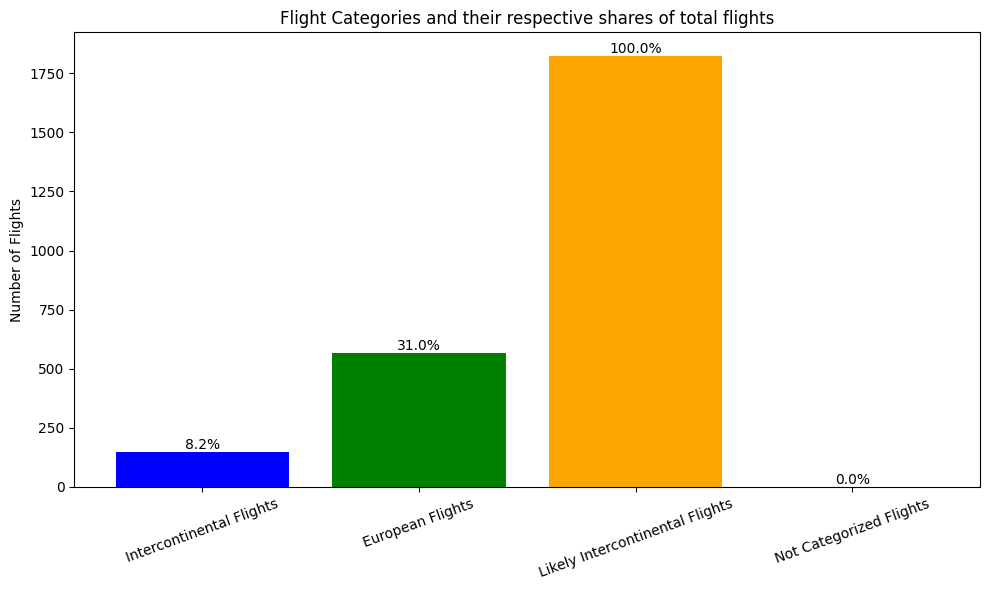

In [212]:
categories = [
    "Intercontinental Flights",
    "European Flights",
    "Likely Intercontinental Flights",
    "Not Categorized Flights"
]

values = [nr_ZRH_intercontinental, nr_ZRH_european, nr_likely_intercontinental_updated, nr_not_categorized]

# Total number of flights for percentage calculation
total_flights = len(data_flights_update)
percentages = [(value / total_flights) * 100 for value in values]

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color=['blue', 'green', 'orange', 'purple'])

# Adding percentage labels on top of each bar
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{percentage:.1f}%', ha='center', va='bottom')

# Customize the plot
plt.ylabel('Number of Flights')
plt.title('Flight Categories and their respective shares of total flights')
plt.xticks(rotation=20)
plt.ylim(0, max(values) + 100)  # Add some space above the tallest bar

# Show the plot
plt.tight_layout()
plt.show()

## 5.5 Reasoning

>Please be aware, since the data split in ch. 0.3 unique flight numbers are used, therefore the amount of flights may be different to other deployments!

>For the last of the three sub-tasks, the following assumption was made: A 'likely' intercontinental flight with two segments and a layover in Europe is a flight with one hop at a european airport either starting or ending in Europe (e.g, Amsterdam -> London -> New York, as well as New York -> London -> Amsterdam are both connections considered in this category and all of their legs, i.e. incl. their european flight segment will be labgelled as such). Also, the task doesn't specify whether the category must be exclusive, therefore the liberty was taken to decide that also previously labelled flights can be part of a likely intercontinental flight.

Taken these assumptions into consideration, the following steps were followed:
1. Creation of Country / Continent Mapping with the help of the Python library ``countryinfo``
2. Creation of a flight_times dataframe, showing the most recent set  of departure and arrival times (fetched by pyflightinfo's ``get_history_by_flight_number()`` function)
3. Classification into the three categories
4. Visualization of results

The first two categories (Intercontinental flights directly to and from Zurich/Switzerland & European flights to and from Zurich/Switzerland) are trivial and can be found our leveraging the created country / continent mapping.

For the last category (Likely intercontinental flights with a European layover) every intercontinental flight starting in europe or arriving in europe was marked as likely intecontinental if this flight had any connecting flights with t-4 (for putbound) or t+4 (for inbound) hours.

In the above visualization, one can see that indeed all flights could be classified with the following numbers:
- Intercontinental flights directly to and from Zurich/Switzerland: 150 (8.2%)
- European flights to and from Zurich/Switzerland: 566 (31%)
- Likely intercontinental flights with a European layover: 1823 (100%)


# 6. Visualize department flights on a world map - 3 points

# 7. Compare departments by their CO2 emissions for European and Intercontinental Flights- 2 points

# References
